STEP 1: Defining our image descriptor

In [13]:
import numpy as np
import cv2
import imutils
class ColorDescriptor:
  def __init__(self, bins):
    # store the number of bins for the 3D histogram
    self.bins = bins

  def describe(self, image):
    # convert the image to the HSV color space and initialize the feature used
    # to quantify the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    features = []

    # grab the dimensions and compute the center of the iamge
    h, w = image.shape[:2]
    cX, cY = h//2, w//2

    # divide the image into four rectangle/segments (top-left, top-right,
    # bottom-left, bottom-right)
    segments = [(0, cX, 0, cY), (cX, w, 0, cY), (cX, w, cY, h), (0, cX, cY, h)]

    # construct an eliptical mask representing the center of the image
    axesX, axesY = (int(w*0.75)//2, int(h*0.75)//2)
    elipMask = np.zeros(image.shape[:2], dtype = np.uint8)
    cv2.ellipse(elipMask, (cX, cY), (axesX, axesY), 0, 0, 360, 255, -1)

    # loop over the segments
    for startX, endX, startY, endY in segments:
      # construct a mask for each corner of the image, subtracting the 
      # elliptical center from it
      cornerMask = np.zeros(image.shape[:2], dtype=np.uint8)
      cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
      cornerMask = cv2.subtract(cornerMask, elipMask)

      # extract a color histogram from the image, then update the feature vector
      hist = self.histogram(image, cornerMask)
      features.extend(hist)

    # extract a color histogram from the elliptical region and update the 
    # feature vector
    hist=self.histogram(image, elipMask)
    features.extend(hist)
    
    return features

  def histogram(self, image, mask):
    # extract a 3D color histogram from the masked region of the image
    # using the supplied number of bins per channel
    hist = cv2.calcHist([image], [0,1,2], mask, self.bins, [0,180,0,256,0,256])

    # normalize the histogram CV is 2.4
    if imutils.is_cv2():
      hist = cv2.normalize(hist).flatten()
    else:
      hist = cv2.normalize(hist, hist).flatten()

    return hist

STEP 2: Extracting Features from Our Dataset

In [19]:
import glob
import cv2
import matplotlib.pyplot as plt

dataset = "/content/drive/MyDrive/colab_img/image_search_engine"
index = "/content/drive/MyDrive/colab_img/csv/features_engine.csv"
cd = ColorDescriptor((8, 12, 3))

# open the output index file for writing
output = open(index, "w")

# use glob to grab the image paths and loop over them
for imagePath in glob.glob(dataset +"/*.jpg"):
  # extract the image id (i.e the unique filename) from the image path and
  # load the image itself
  imageID = imagePath[imagePath.rfind('/') + 1:]
  image = cv2.imread(imagePath)

  # describe the image
  features = cd.describe(image)

  # write the features to file
  features = [str(f) for f in features]
  output.write("%s, %s\n"%(imageID, ",".join(features)))

output.close()

STEP 3: The Searcher

In [20]:
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt

class Searcher:
  def __init__(self, indexPath):
    # store our index path
    self.indexPath = indexPath

  def search(self, queryFeatures, limit=10):
    # initialize our dictionary of results
    results = {}

    # open the index file for reading
    with open(indexPath) as f:
      # initialize the CSV reader
      reader = csv.reader(f)

      # loop over the rows in the index
      for row in reader:
        # parse out the image ID and features, then compute the chi-squared
        # distance between the features in our index and our query feature
        features = [float(x) for x in row[1:]]
        d = self.chi2_squared(features, queryFeatures)

        # now that we have the distance between the two feature vectors, we can
        # update the results dictionary -- the key is the current image ID just
        # computed, representing how 'similar' the image in the index is to our
        # query
        results[row[0]] = d

      f.close()

    # sort our results, so that the smaller distances (i.e the more relevant
    # images are at the front of the list)
    results = sorted([(v, k) for (k, v) in results.items()])

    return results[:limit]

  def chi2_squared(self,histA, histB, eps = 1e-10):
    return 0.5 * np.sum([(a-b)**2/(a+b+eps) for a,b in zip(histA, histB)])
    

STEP 4: Performing a Search

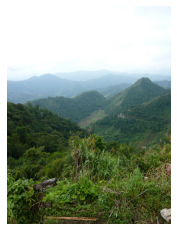

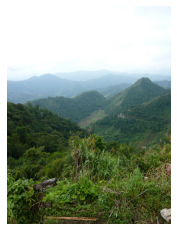

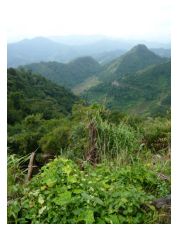

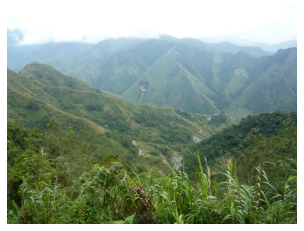

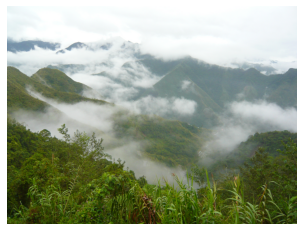

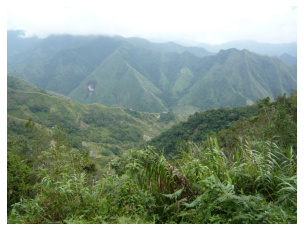

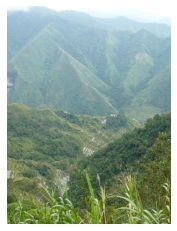

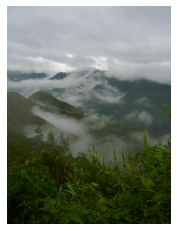

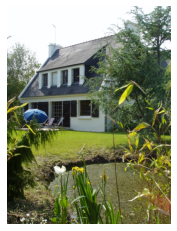

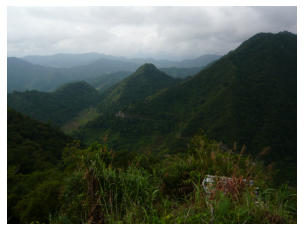

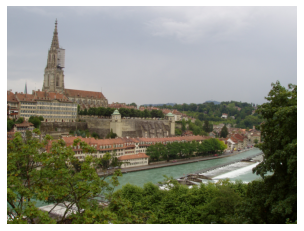

In [22]:
import cv2
indexPath = "/content/drive/MyDrive/colab_img/csv/features_engine.csv"
queryImage = "100000.jpg"
resultPath = "/content/drive/MyDrive/colab_img/image_search_engine"

def show(*images):
  for i, image in enumerate(images):
    plt.subplot(1, len(images), i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
  plt.show()

cd = ColorDescriptor((8,12,3))

# load the query image and describe it
query = cv2.imread(resultPath+"/"+queryImage)
features = cd.describe(query)

# perform the search
searcher = Searcher(indexPath)
results = searcher.search(features)

# display the query
show(query)

# loop over the results
for score, resultID in results:
  result = cv2.imread(resultPath+"/"+resultID)
  show(result)